#Leveraging a pretrained model
Feature extraction with a pretrained model
Instantiating the VGG16 convolutional base

In [1]:

from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


#Summary of the model

In [2]:


conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#Downloading the dataset

In [2]:


from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
 99% 808M/812M [00:02<00:00, 307MB/s]
100% 812M/812M [00:02<00:00, 309MB/s]


#Creating directory and splitting dataset into train,validation and test sets

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train5", start_index=0, end_index=1000)
make_subset("validation5", start_index=1000, end_index=1500)
make_subset("test5", start_index=1500, end_index=2000)

#Re-shaping the images

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train5",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation5",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test5",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# Extracting the VGG16 features and corresponding labels

In [5]:


import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)


1/1 [==============================] - 0s 23ms/step


In [6]:
train_features.shape

(2000, 5, 5, 512)

# Defining and training the densely connected classifier

In [7]:

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=6,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)



Epoch 1/6
63/63 [==============================] - 3s 8ms/step - loss: 19.1714 - accuracy: 0.9245 - val_loss: 3.5684 - val_accuracy: 0.9650
Epoch 2/6
63/63 [==============================] - 0s 4ms/step - loss: 3.8003 - accuracy: 0.9700 - val_loss: 5.1082 - val_accuracy: 0.9610
Epoch 3/6
63/63 [==============================] - 0s 4ms/step - loss: 1.7193 - accuracy: 0.9865 - val_loss: 5.0248 - val_accuracy: 0.9630
Epoch 4/6
63/63 [==============================] - 0s 4ms/step - loss: 1.1619 - accuracy: 0.9885 - val_loss: 4.0655 - val_accuracy: 0.9750
Epoch 5/6
63/63 [==============================] - 0s 4ms/step - loss: 0.8941 - accuracy: 0.9935 - val_loss: 4.9013 - val_accuracy: 0.9720
Epoch 6/6
63/63 [==============================] - 0s 4ms/step - loss: 1.2454 - accuracy: 0.9935 - val_loss: 4.9271 - val_accuracy: 0.9700


# Plotting the results

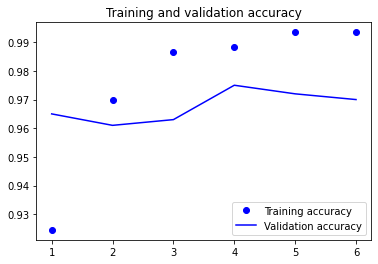

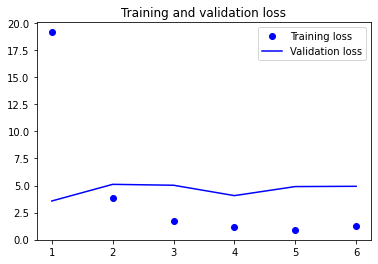

In [8]:

import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


#Feature extraction together with data augmentation
#Instantiating and freezing the VGG16 convolutional base

In [9]:

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


# Printing the list of trainable weights before and after freezing

In [10]:


conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26


In [11]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights after freezing the conv base: 0


# Adding a data augmentation stage and a classifier to the convolutional base

In [40]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.9)(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=6,
    validation_data=validation_dataset,
    callbacks=callbacks)

63/63 [==============================] - 7s 111ms/step - loss: 38.4525 - accuracy: 0.7790 - val_loss: 3.5605 - val_accuracy: 0.9680


# Evaluating the model on the test set

In [45]:

test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")



32/32 [==============================] - 1s 16ms/step - loss: 5.5635 - accuracy: 0.9560
Test accuracy: 0.956


# Fine-tuning a pretrained model

In [42]:


conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#Freezing all layers until the fourth from the last

In [43]:


conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
    

#Fine-tuning the model

In [46]:


model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=6,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/6


157/157 [==============================] - 20s 103ms/step - loss: 2.3987 - accuracy: 0.9882 - val_loss: 7.2690 - val_accuracy: 0.9580
Epoch 2/6
157/157 [==============================] - 16s 100ms/step - loss: 2.2742 - accuracy: 0.9872 - val_loss: 7.3012 - val_accuracy: 0.9600
Epoch 3/6
157/157 [==============================] - 16s 100ms/step - loss: 2.0024 - accuracy: 0.9886 - val_loss: 7.2703 - val_accuracy: 0.9600
Epoch 4/6
157/157 [==============================] - 16s 101ms/step - loss: 2.0066 - accuracy: 0.9878 - val_loss: 7.2840 - val_accuracy: 0.9600
Epoch 5/6
157/157 [==============================] - 16s 102ms/step - loss: 2.2211 - accuracy: 0.9886 - val_loss: 7.2210 - val_accuracy: 0.9600
Epoch 6/6
157/157 [==============================] - 16s 101ms/step - loss: 1.8825 - accuracy: 0.9882 - val_loss: 7.2290 - val_accuracy: 0.9620


#Testing tuned model in test test

In [45]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 17ms/step - loss: 8.6010 - accuracy: 0.9680
Test accuracy: 0.968
